In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import omegaconf
import hydra
from lightning import Callback, LightningDataModule, LightningModule, Trainer
from omegaconf import DictConfig
from sklearn.preprocessing import StandardScaler
from fgvc.data.plant_traits_data import *

### Load Dataframes

In [12]:
df_train = pd.read_csv('/home/ubuntu/FGVC11/data/PlantTrait/train.csv')
df_train['path'] = '/home/ubuntu/FGVC11/data/PlantTrait/train_images/' + df_train['id'].astype(str) + '.jpeg'

df_test = pd.read_csv('/home/ubuntu/FGVC11/data/PlantTrait/test.csv')
df_test['path'] = '/home/ubuntu/FGVC11/data/PlantTrait/test_images/' + df_test['id'].astype(str) + '.jpeg'

In [13]:
#all columns must be identical to be consider the same species
trait_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
aux_columns = list(
            map(lambda x: x.replace("mean", "sd"), trait_columns)
        )
metadata_cols = df_train.drop(
                columns=["id", "path"] + trait_columns + aux_columns
            ).columns

### Cleaning DataFrames

In [14]:
for col in trait_columns:
    upper_quantile = df_train[col].quantile(0.98)  
    df_train = df_train[(df_train[col] < upper_quantile)]
    df_train = df_train[(df_train[col] > 0)]  

### Train/Val/Test Splits

In [15]:
# add species column
df_train['species'] = df_train.groupby(trait_columns).ngroup()
df_train['species'] = df_train['species'].astype(str)
species_counts = df_train['species'].nunique()
print (f"{species_counts} unique species found in {len(df_train)} records")

17396 unique species found in 49009 records


In [19]:
# add a split column and do train_testsplit based on species column
df_train['split'] = 'train'
# create a dictionary to store the indices of each species
species_indices = {}

# iterate over each species and select 20% of its indices for validation
for species in tqdm(df_train['species'].unique()):
    species_indices[species] = np.random.choice(df_train[df_train['species'] == species].index, 
                                                size=int(len(df_train[df_train['species'] == species]) * 0.3), 
                                                replace=False)

# update the split column for the selected validation indices
df_train.loc[np.concatenate(list(species_indices.values())), 'split'] = 'val'


  0%|          | 0/17396 [00:00<?, ?it/s]

In [21]:
# add test data into a common dataframe
df_test["split"] = "test"
df_full = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
# fill NAs
df_full.fillna(0, inplace=True)

In [22]:
df_full['split'].value_counts()

train    43037
test      6545
val       5972
Name: split, dtype: int64

### Normalize Metadata Columns

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scale = StandardScaler()
df_full[metadata_cols] = scale.fit_transform(df_full[metadata_cols])


In [ ]:
# save the data
# df_full.to_csv('/home/ubuntu/FGVC11/data/PlantTrait/df_processed.csv', index=False)

### Visualize Label Encoder
Mean and STD values were first calculated separately and then hardcoded in the method
```
self.mean = torch.nn.Parameter(
        torch.tensor(
            [-0.3060, 1.1513, -0.0671, 0.1698, 0.3407, 2.7966],
            dtype=torch.float32,
        ),
        requires_grad=False,
        )
self.std = torch.nn.Parameter(
    torch.tensor(
        [0.1226, 0.2133, 0.6449, 0.1594, 0.9975, 0.6355],
        dtype=torch.float32,
    ),
    requires_grad=False,
        )
```

In [24]:
from fgvc.models.plant_traits_model import LabelEncoder
le = LabelEncoder()

Before Label Encoding


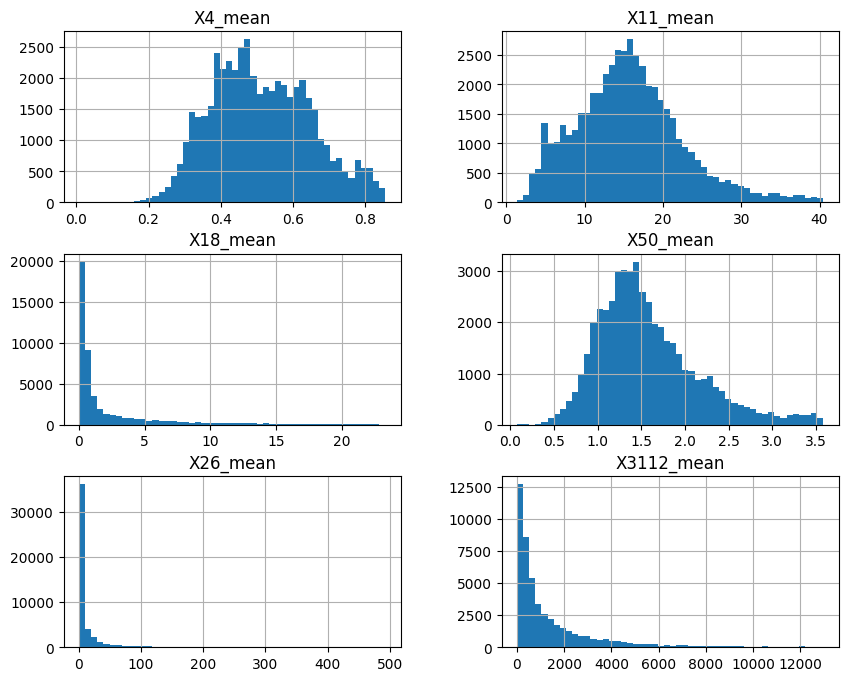

After Label Encoding


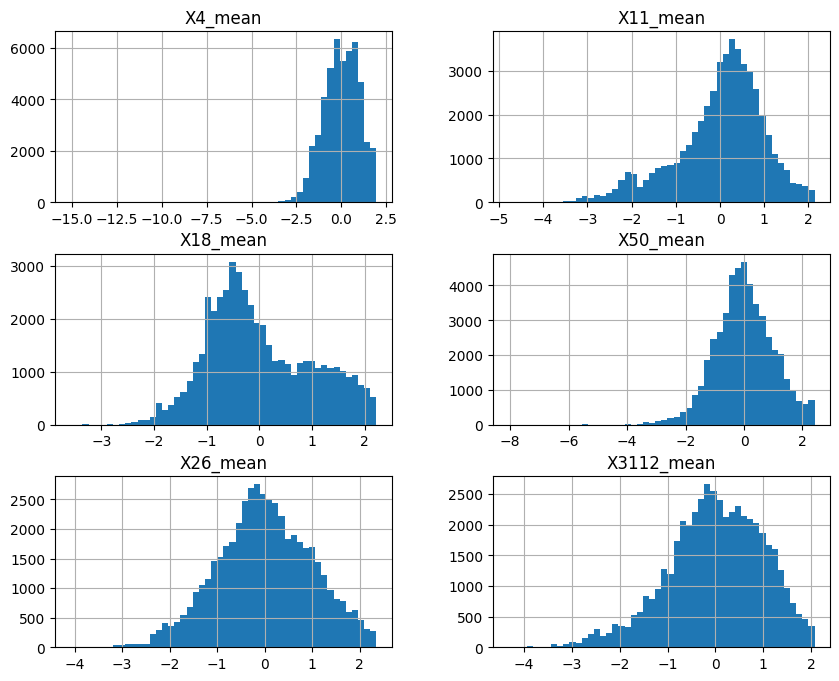

In [26]:
print("Before Label Encoding")
df_full[trait_columns][df_full.split != "test"].hist(bins=50, figsize=(10, 8))
plt.show()
print("After Label Encoding")
X = torch.Tensor(df_full[trait_columns][df_full.split != "test"].values)
t = le.transform(X)
t = pd.DataFrame(t, columns=trait_columns)
t.hist(bins=50, figsize=(10, 8))
plt.show()

### Save Specie Traits as tensor

In [32]:
df_species_traits = df_full.groupby('species')[trait_columns].first().reset_index()
specie_traits = torch.tensor(df_species_traits[trait_columns].values, dtype=torch.float32)[1:]

In [ ]:
# save
# torch.save(specie_traits, '/home/ubuntu/FGVC11/data/PlantTrait/specie_traits.pt')